In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import sys

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
print(os.environ['CUDA_VISIBLE_DEVICES'])

In [3]:
sys.path.append('../src/cWGAN/')
import model

In [4]:
save_dir = '../models/cWGAN/Run_2020-12-01_35/'
assert(os.path.isdir(save_dir))

In [5]:
#losses = np.loadtxt(save_dir + 'losses.txt', skiprows=1)


losses = []
with open(save_dir+'losses.txt', 'r') as f:
    for _ in range(2000):
        line = f.readline()
        start = int(line.find('('))
        end = int(line.find(','))
        if start > 0:
            losses.append(float(line[start+1:end]))

#print(losses)

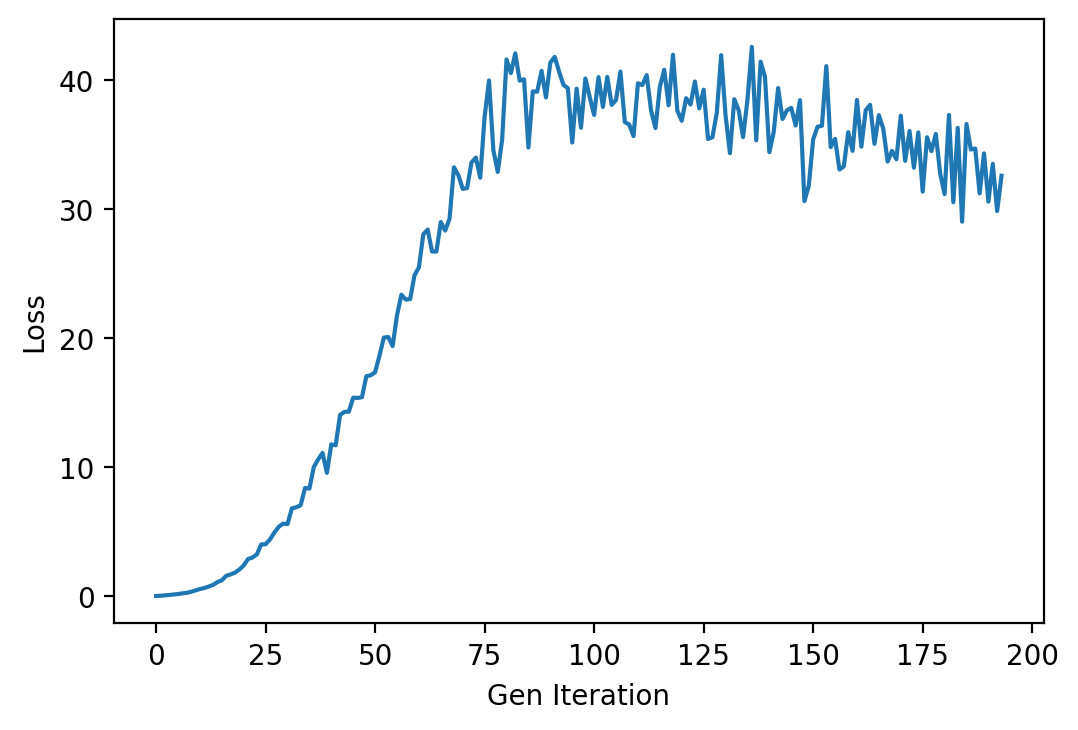

In [6]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

ax.plot(losses)
#ax.plot(losses[:, 1], label='Training Gen Loss')
#ax.plot(losses[:, 2], label='Training Disc Loss')
#ax.plot(losses[:, 1]/losses[0, 1], label='Training Gen Loss')
#ax.plot(losses[:, 2]/losses[0, 2], label='Training Disc Loss')
#ax.plot(losses[:, 3]/losses[0, 1], label='Val Gen Loss')
#ax.plot(losses[:, 4]/losses[0, 2], label='Val Disc Loss')
#ax.set_ylim(0.0075, 0.012)
ax.set_ylabel("Loss")
ax.set_xlabel("Gen Iteration")
#plt.yscale('log')
#ax.legend()
plt.show()

In [7]:
data = np.loadtxt("../data/processed/matchedJets.txt", skiprows=2)

In [8]:
print(data[0])

[41.4024   -1.27316  -0.891338 80.6118   36.3716   -1.24909  -0.87713
 69.0265  ]


In [9]:
partonPtMax = np.max(data[:, 0], axis=0)
partonPtMin = np.min(data[:, 0], axis=0)
partonMean = np.mean(data[:, 1:3], axis=0)
partonStd = np.std(data[:, 1:3], axis=0)
partonEMax = np.max(data[:, 3], axis=0)
partonEMin = np.min(data[:, 3], axis=0)
pfPtMax = np.max(data[:, 4], axis=0)
pfPtMin = np.min(data[:, 4], axis=0)
pfMean = np.mean(data[:, 5:7], axis=0)
pfStd = np.std(data[:, 5:7], axis=0)
pfEMax = np.max(data[:, 7], axis=0)
pfEMin = np.min(data[:, 7], axis=0)
data[:, 0] = (data[:, 0] - partonPtMin)/partonPtMax
data[:, 1:3] = (data[:, 1:3] - partonMean)/partonStd
data[:, 3] = (data[:, 3] - partonEMin)/partonEMax
#data[:, 4] = (data[:, 4] - pfPtMin)/pfPtMax
#data[:, 5:7] = (data[:, 5:7] - pfMean)/pfStd
#data[:, 7] = (data[:, 7] - pfEMin)/pfEMax
num_batches = int(len(data)/64)
print(num_batches)

trainParton = data[:, :4]
trainPf = data[:, 4:]
train_dataset = tf.data.Dataset.from_tensor_slices((trainParton, trainPf))


10101


In [10]:
cwgan = model.cWGAN(5, 64)

In [20]:
cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_2')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ../models/cWGAN/Run_2020-12-01_35//training_checkpoints/gen_2

In [12]:
print(data[0])

[ 1.53818124e-02 -8.89597460e-01 -4.90113027e-01  1.24261265e-02
  3.63716000e+01 -1.24909000e+00 -8.77130000e-01  6.90265000e+01]


In [13]:
noise = np.random.normal(size=data[:, 0:4].shape)
print(noise.shape)

(646517, 4)


In [14]:
%%time
predict = cwgan.generator.predict([data[:, 0:4], noise])

CPU times: user 12.7 s, sys: 874 ms, total: 13.6 s
Wall time: 8.47 s


In [15]:
print(predict[0])

[-0.01044602  0.34930006 -0.03196952 -0.04214123]


In [16]:
predict[:, 0] = predict[:, 0]*partonPtMax + partonPtMin
predict[:, 1:3] = predict[:, 1:3] * partonStd + partonMean
predict[:, 3] = predict[:, 3]*partonEMax + partonEMin

In [17]:
data[:, 0] = data[:, 0]*partonPtMax + partonPtMin
data[:, 1:3] = data[:, 1:3] * partonStd + partonMean
data[:, 3] = data[:, 3]*partonEMax + partonEMin

In [18]:
print(predict[0])
print(data[0])

[ 5.4658165e+00  4.9722785e-01 -5.9885554e-02 -1.8478854e+02]
[41.4024   -1.27316  -0.891338 80.6118   36.3716   -1.24909  -0.87713
 69.0265  ]


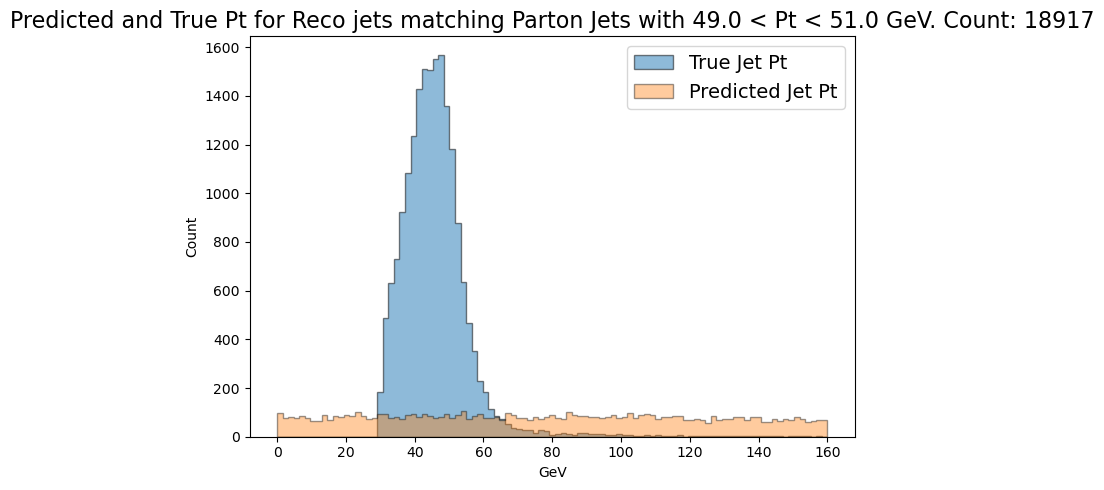

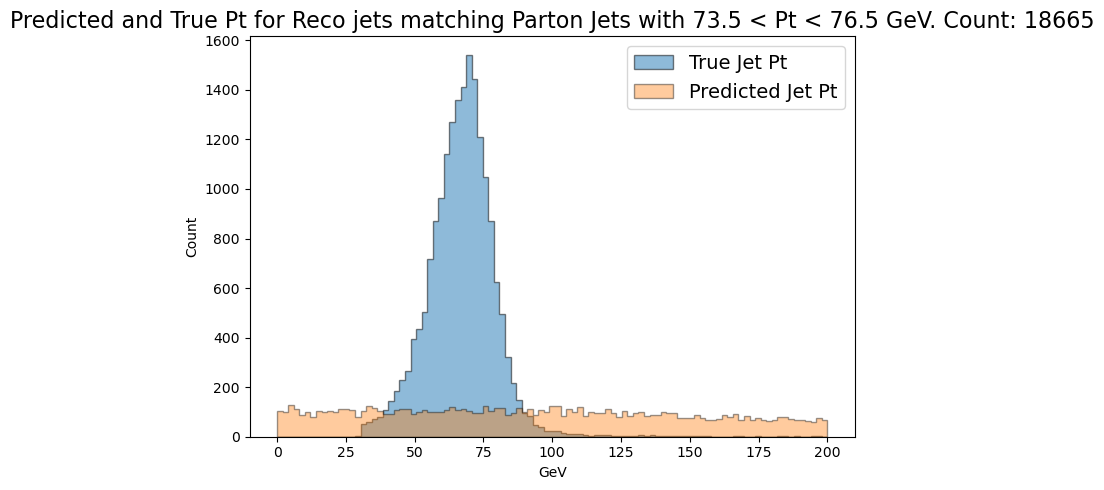

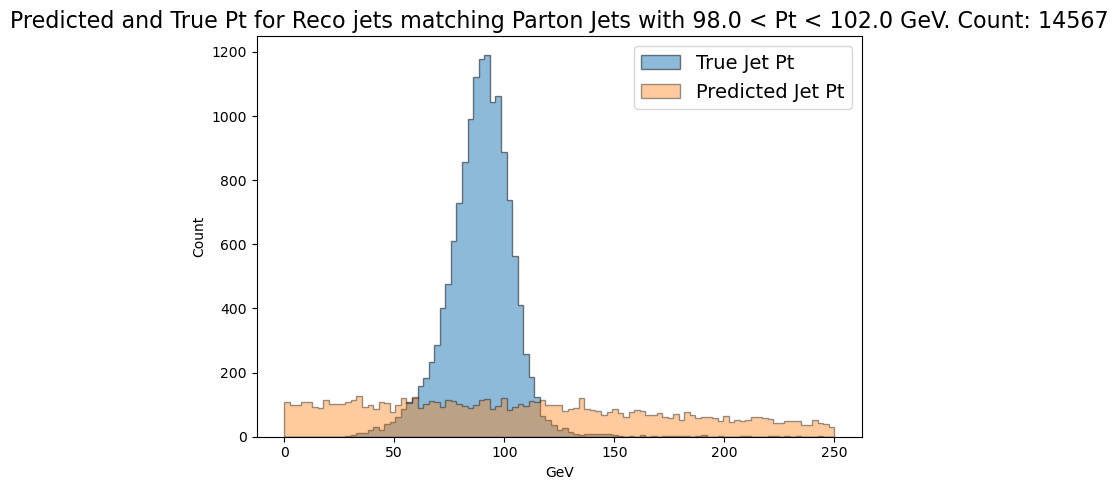

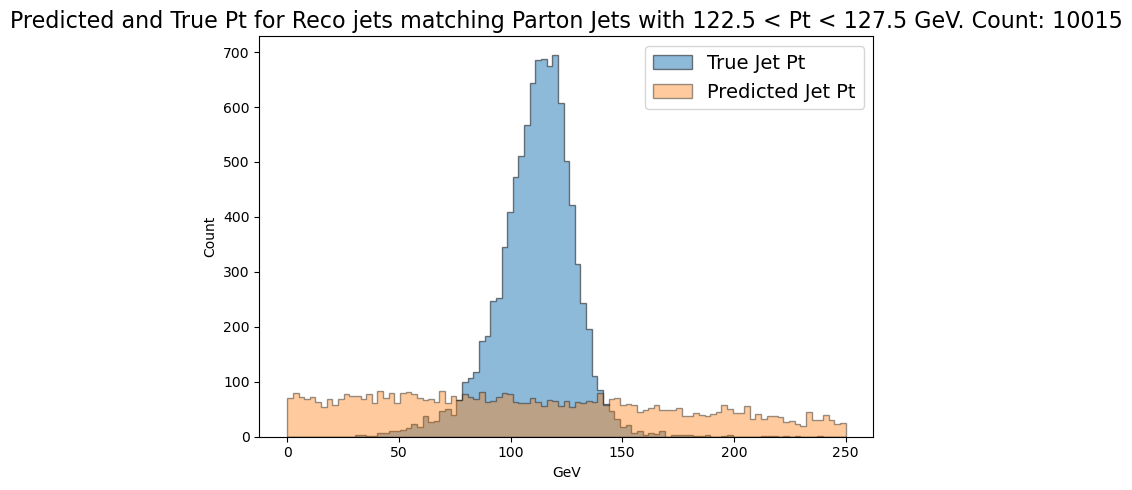

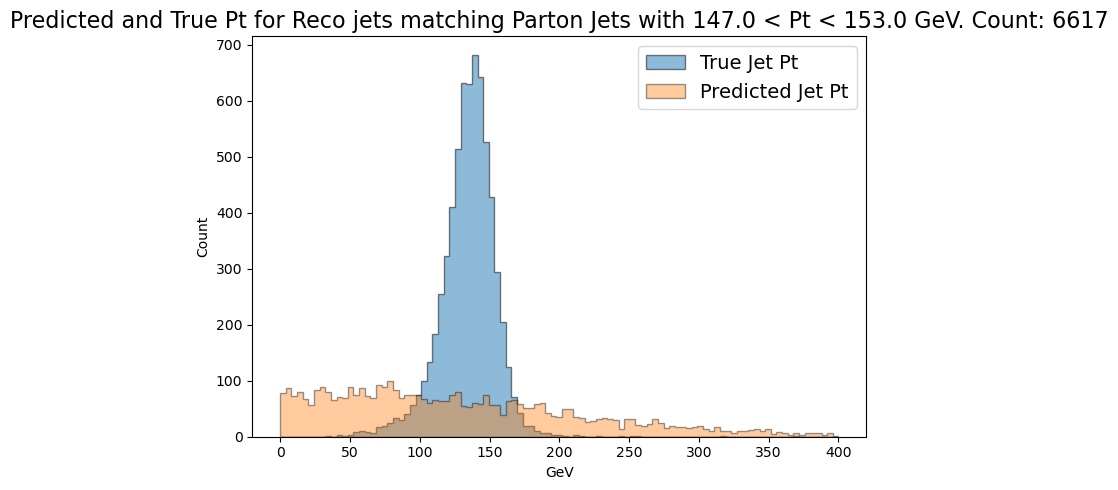

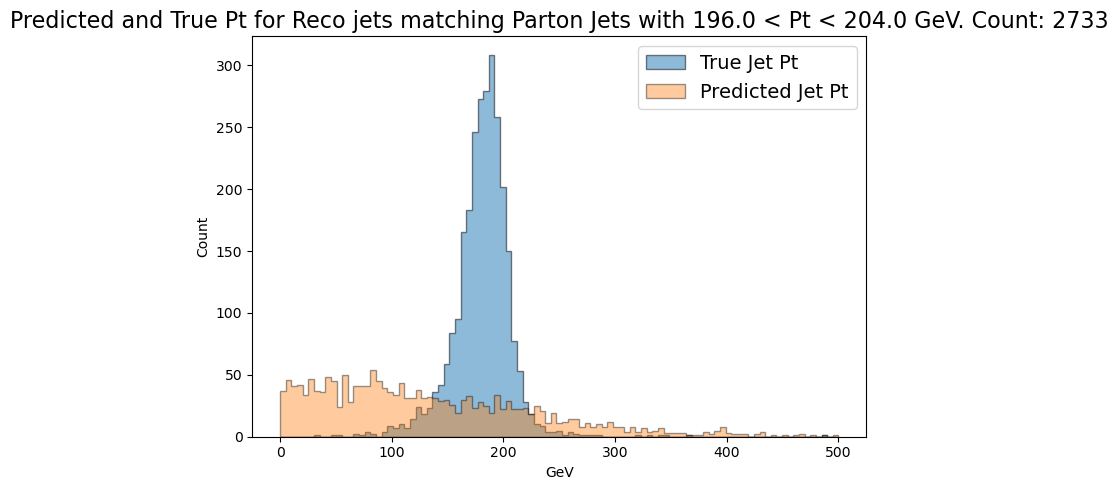

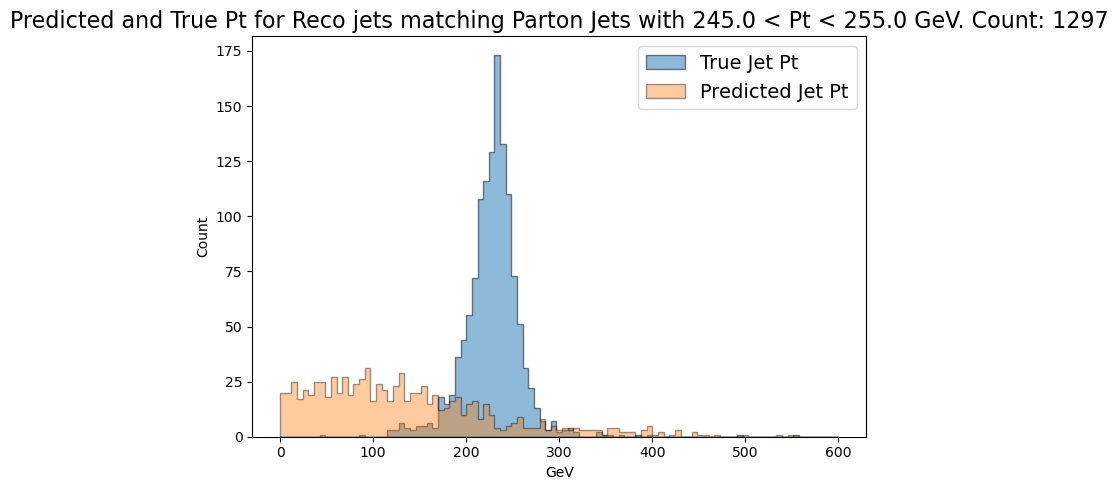

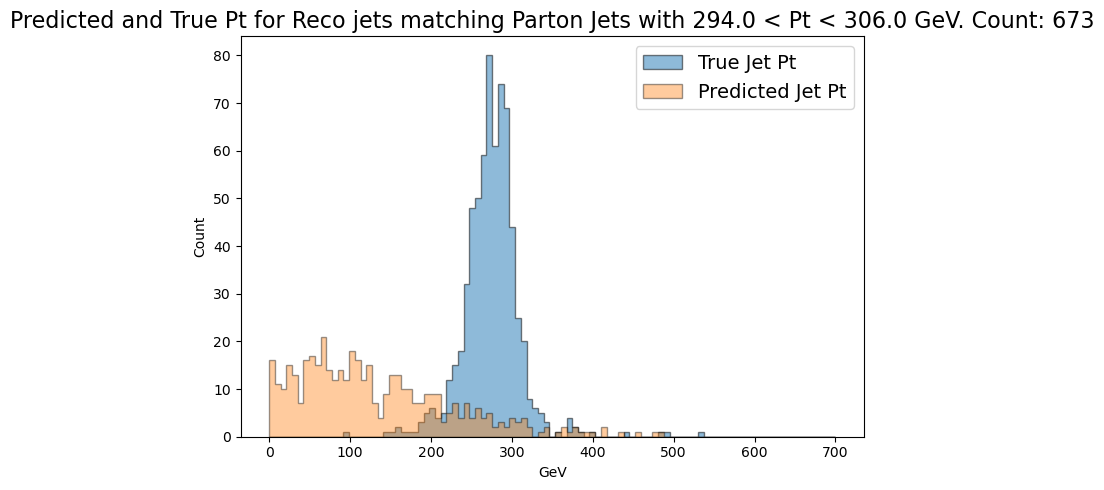

In [19]:
range_highs = [160, 200, 250, 250, 400, 500, 600, 700]
range_lows = [0, 0, 0, 0, 0, 0, 0, 0]
j = 0
for center in [50, 75, 100, 125, 150, 200, 250, 300]:        
    recoPt = []
    predPt = []
    low = center - center/50
    high = center + center/50
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            recoPt.append(data[i, 4])
            predPt.append(predict[i, 0])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(7,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(recoPt, bins=bins, label='True Jet Pt', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(predPt, bins=bins, label='Predicted Jet Pt', alpha=0.4, ec="k", histtype='stepfilled')
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("Predicted and True Pt for Reco jets matching Parton Jets with {} < Pt < {} GeV. Count: {}".format(low, high, len(recoPt)), fontsize=16)
    #ax.axvline(x=center/2)

    ax.legend(fontsize=14)
    plt.tight_layout()
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig("PtDistLog{}.pdf".format(j), facecolor="white", transparent="True")
    j+=1
